In [3]:

# just to make the cells appear wider:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import string


/var/folders/lc/vg4hc2nn2pn05y4lw3h5wmpm0000gn/T/ipykernel_4782/3036708214.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
# run it using:

# # Uncomment this below and copy paste it to run in terminal 
# python3 FastCosmicIntegration.py  --dco_type "BHNS", , withinHubbleTime=merges_hubble_time, pessimistic=pessimistic_CEE, noRLOFafterCEE=no_RLOF_after_CEE --mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 --weight 'weight' --zstep 0.01 --sens O3 --m1min 10. --aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7 --path '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_BHNS_A.h5'
python3 FastCosmicIntegration.py  --dco_type "BNS" --mu0 0.035 --muz -0.23 --sigma0 0.39 --sigmaz 0.0 --alpha 0.0 --weight 'weight' --zstep 0.01 --sens O3 --m1min 5. --aSF 0.01 --bSF 2.77 --cSF 2.9 --dSF 4.7 --withinHubbleTime False --pessimistic True --noRLOFafterCEE False --path '/Volumes/Andromeda2/DATA/AllDCO_bugfix/fiducial/COMPASCompactOutput_BNS_A.h5'

In [ ]:
# plotting 

In [30]:


fileLoc    =  '/Volumes/Andromeda2/DATA/AllDCO_bugfix/massTransferEfficiencyFixed_0_75/'
filename   = 'COMPASCompactOutput_BBH_D.h5'

full_data_path = fileLoc + filename

################################################
## Open hdf5 file
File        = h5.File(fileLoc + filename ,'r')

print(File.keys())

# The group that contains the rate data
rate_key = 'Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0'
################################################
## Read merger rate related data
# redshifts                 = File[rate_key]['redshifts'][()] # Redshifts at which the rates were calculated
# O1_detection_rate         = File[rate_key]['detection_rateO3'][()] # detection rate for O3 sensitivity 

# Read the DCO masses, Select only merging BBHs
Mass1              = File['doubleCompactObjects']['M1'] # reads in the mass in [Msun] 
Mass2              = File['doubleCompactObjects']['M2'] # reads in the mass in [Msun] 
weight              = File['doubleCompactObjects']['weight'] # reads in the mass in [Msun]
M_moreMassive      = np.maximum(Mass1, Mass2)
M_lessMassive      = np.minimum(Mass1, Mass2)
del Mass1
del Mass2 
print(len(M_moreMassive ))
print(len(weight))

optimisticCommonEnvelopeFlag = File["commonEnvelopes"]["optimisticCommonEnvelopeFlag"]
print(np.sum(optimisticCommonEnvelopeFlag))
immediateRLOFAfterCEE = File["commonEnvelopes"]["immediateRLOFAfterCEE"]
print(np.sum(immediateRLOFAfterCEE))
File.close()





<KeysViewHDF5 ['RLOF', 'commonEnvelopes', 'doubleCompactObjects', 'formationChannels', 'supernovae', 'systems', 'weights_detected', 'weights_detectedPerRedshift', 'weights_intrinsic', 'weights_intrinsicPerRedshift']>
6033721
6033721
0
1891


In [24]:
stellar_type_1, stellar_type_2, hubble_flag, dco_seeds = \
    get_COMPAS_variables("doubleCompactObjects", ["stellarType1", "stellarType2", "mergesInHubbleTimeFlag", "seed"])

if types == "CHE_BBH" or types == "NON_CHE_BBH":
    stellar_type_1_zams, stellar_type_2_zams, che_ms_1, che_ms_2, sys_seeds = \
        get_COMPAS_variables("systems", ["Stellar_Type@ZAMS(1)", "Stellar_Type@ZAMS(2)", "SEED"])

    che_mask  = np.logical_and.reduce((stellar_type_1_zams == 16, stellar_type_2_zams == 16, che_ms_1 == True, che_ms_2 == True))
    che_seeds = sys_seeds[()][che_mask]

CHE_mask = np.in1d(dco_seeds, che_seeds) if types == "CHE_BBH" or types == "NON_CHE_BBH" else np.repeat(False, len(dco_seeds)) #// Floor 

# if user wants to mask on Hubble time use the flag, otherwise just set all to True
hubble_mask = hubble_flag.astype(bool) if withinHubbleTime else np.repeat(True, len(dco_seeds))

# mask on stellar types (where 14=BH and 13=NS), BHNS can be BHNS or NSBH
type_masks = {
    "all": np.repeat(True, len(dco_seeds)),
    "BBH": np.logical_and(stellar_type_1 == 14, stellar_type_2 == 14),
    "BHNS": np.logical_or(np.logical_and(stellar_type_1 == 14, stellar_type_2 == 13), np.logical_and(stellar_type_1 == 13, stellar_type_2 == 14)),
    "BNS": np.logical_and(stellar_type_1 == 13, stellar_type_2 == 13),
}
type_masks["CHE_BBH"]     = np.logical_and(CHE_mask, type_masks["BBH"]) if types == "CHE_BBH" else np.repeat(False, len(dco_seeds))
type_masks["NON_CHE_BBH"] = np.logical_and(np.logical_not(CHE_mask), type_masks["BBH"]) if types == "NON_CHE_BBH" else np.repeat(True, len(dco_seeds))

# if the user wants to make RLOF or optimistic CEs
if noRLOFafterCEE or pessimistic:

    # get the flags and unique seeds from the Common Envelopes file
    ce_seeds = get_COMPAS_variables("commonEnvelopes", "randomSeed")
    dco_from_ce = np.in1d(ce_seeds, dco_seeds)
    dco_ce_seeds = ce_seeds[dco_from_ce]

    # if masking on RLOF, get flag and match seeds to dco seeds
    if noRLOFafterCEE:
        rlof_flag = get_COMPAS_variables("commonEnvelopes", "immediateRLOFAfterCEE")[dco_from_ce].astype(bool)
        rlof_seeds = np.unique(dco_ce_seeds[rlof_flag])
        rlof_mask = np.logical_not(np.in1d(dco_seeds, rlof_seeds))
    else:
        rlof_mask = np.repeat(True, len(dco_seeds))

    # if masking on pessimistic CE, get flag and match seeds to dco seeds
    if pessimistic:
        pessimistic_flag = get_COMPAS_variables("commonEnvelopes", "optimisticCommonEnvelopeFlag")[dco_from_ce].astype(bool)
        pessimistic_seeds = np.unique(dco_ce_seeds[pessimistic_flag])
        pessimistic_mask = np.logical_not(np.in1d(dco_seeds, pessimistic_seeds))
    else:
        pessimistic_mask = np.repeat(True, len(dco_seeds))
else:
    rlof_mask = np.repeat(True, len(dco_seeds))
    pessimistic_mask = np.repeat(True, len(dco_seeds))

NameError: name 'get_COMPAS_variables' is not defined

In [18]:
File        = h5.File(fileLoc + filename ,'r')

print(File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0'].keys())


w_0 = File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0']['merger_rate_z0'][...].squeeze()

print(w_0)
redshifts = File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0']['redshifts'][...].squeeze()
print('available redshifts are: ', redshifts, ' this gives %s options'%len(redshifts))

w_per_z_per_system = File['Rates_mu00.035_muz-0.23_alpha0.0_sigma00.39_sigmaz0.0']['merger_rate'][...].squeeze()

print(np.shape(w_per_z_per_system))

z_index = 3

print('the redshift weights per system at z = ', redshifts[z_index], ' are given by' )
w_z_index =w_per_z_per_system[:,z_index]
print(len(w_z_index))



<KeysViewHDF5 ['DCOmask', 'SEED', 'detection_rateO3', 'merger_rate', 'merger_rate_z0', 'redshifts']>
[2.87144148e-48 2.85379854e-47 6.04963904e-51 ... 7.28589266e-05
 7.90357441e-05 2.60657742e-04]
available redshifts are:  [ 0.    0.01  0.02 ...  9.98  9.99 10.  ]  this gives 1001 options
(233137, 100)
the redshift weights per system at z =  0.03  are given by
233137


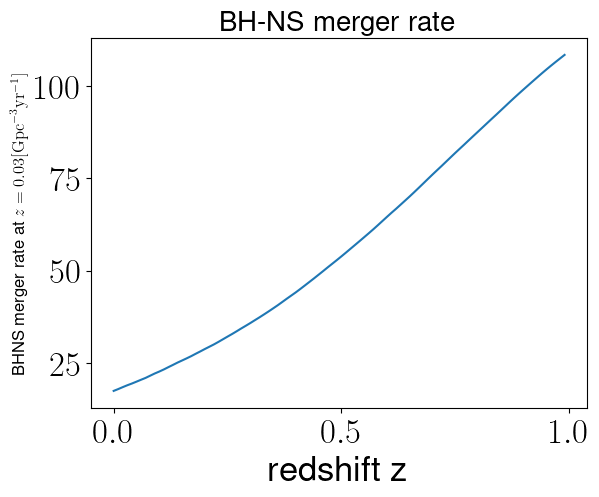

In [23]:

plt.plot(redshifts[:100], np.sum(w_per_z_per_system, axis=0)[:100])
plt.xlabel('redshift z')
plt.ylabel(r'BHNS merger rate at $z =%s [\rm{Gpc}^{-3} \rm{yr}^{-1}]$'%np.round(redshifts[z_index],3), fontsize=12)
plt.title('BH-NS merger rate', fontsize=20)
plt.show()